#Финальный проект обучения курса CV-инженер

##Описание проекта

Бизнес цель:

В последние годы мы наблюдаем интересную тенденцию: люди всё чаще тренируются у себя дома. Занятия с тренером в спортзале уходят в прошлое, и на смену им приходит новая реальность, в которой люди занимаются спортом, глядя в монитор.

Но если рядом нет тренера, кто же подскажет, правильно ли выполняется то или иное упражнение?

Специально для таких случаев мы хотим создать виртуального коуча, который поможет людям выполнять физические упражнения без вреда здоровью.

С помощью нашего приложения пользователь сможет удостовериться в правильности и эффективности действий, просто загрузив видео со своей тренировкой. Приложение сравнит его движения с движениями тренера и даст рекомендации.

Техническая цель: Разработать модель машинного обучения способную распознавать позу человека на видео и сравнивать ее сходство с эталонной, для последующего сипользования в приложении виртуального тренера

Задачи:
1. Построение каркаса позы через ключевые точки.
2. Оценка сходства поз по фотографии.
3. Валидация оценки позы на видео.
4. Создание готовой к исползованию в продакшене модели

В этом ноутбуке представлено решение 1 и 2 задачи

## ЗАДАЧА 1 - Обработка фотографий и построение каркаса позы человека через ключевые точки

### Загрузка необходимых библиотек

In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torchvision
from torchvision.transforms import v2
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


###Подготовка модели

В качестве основы возьмем предобученную модель KeypointRCNN на базе ResNet50 из пакета torchvision

In [2]:
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 164MB/s]


In [3]:
print(model)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

###Подготовка данных и загрузка изображений

Создадим список ключевых точек выдаваемых моделью

In [4]:
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

Загрузка изображения

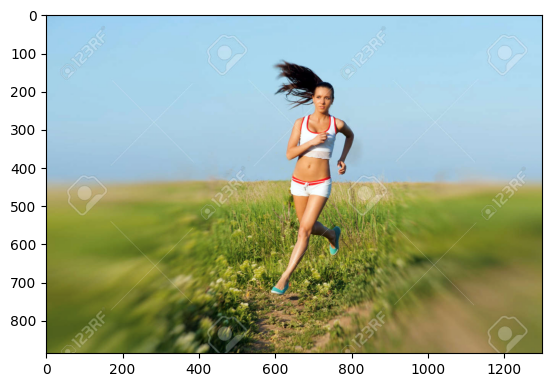

In [5]:
runing_girl_img = cv2.imread('runing_girl.png')
runing_girl_img = cv2.cvtColor(runing_girl_img, cv2.COLOR_BGR2RGB)
plt.imshow(runing_girl_img)

Подготовка трансформций для изображения - будем использовать изменение размера и преобразование в torch.tensor

In [6]:
transform = v2.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([800,])])
transf_runing_girl_img = transform(runing_girl_img)

In [7]:
print(type(transf_runing_girl_img), transf_runing_girl_img.shape)

<class 'torch.Tensor'> torch.Size([3, 800, 1173])


###Обработка изображения моделью и визуализация результатов

Подадим изображение в модель

In [8]:
model.eval()
output_runing_girl = model(transf_runing_girl_img.unsqueeze(0))

Визуализируем ключевые точки детектированные моделью

In [9]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    if(type(img) == torch.Tensor):
      img = img.permute(1, 2, 0).numpy()
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]))
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

In [10]:
result = draw_keypoints_per_person(transf_runing_girl_img, output_runing_girl[0]['keypoints'], output_runing_girl[0]['keypoints_scores'], output_runing_girl[0]['scores'])

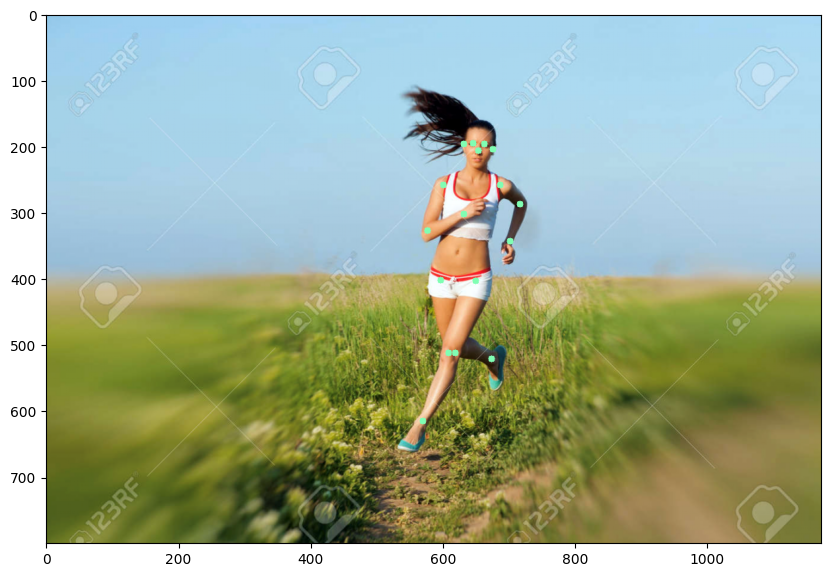

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(result)

Итак модель хорошо находит ключевые точки.


Теперь отрисуем получившийся каркас тела поэтим лючевым точкам.

Для этого подготовим список  конечностей по двум точкам - начало и конец

In [12]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs


limbs = get_limbs_from_keypoints(keypoints)

Отрисуем получившийся скелет

In [13]:
def draw_skillet(img, all_keypoints, all_scores, confs, limbs, keypoint_threshold=2, conf_threshold=0.9):
    if(type(img) == torch.Tensor):
      img = img.permute(1, 2, 0).numpy()
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        kp_array=[]
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            keypoints_restored = []
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    keypoints_restored.append(keypoint)
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]))
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)
            for limb in limbs:
              first = limb[0]
              second = limb[1]
              if (scores[first] and scores[second])>keypoint_threshold:
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1]))
                cv2.line(img_copy, keypoints_restored[first], keypoints_restored[second], color, 3)

    return img_copy

In [14]:
runing_girl_result_img = draw_skillet(transf_runing_girl_img, output_runing_girl[0]['keypoints'], output_runing_girl[0]['keypoints_scores'], output_runing_girl[0]['scores'], limbs)

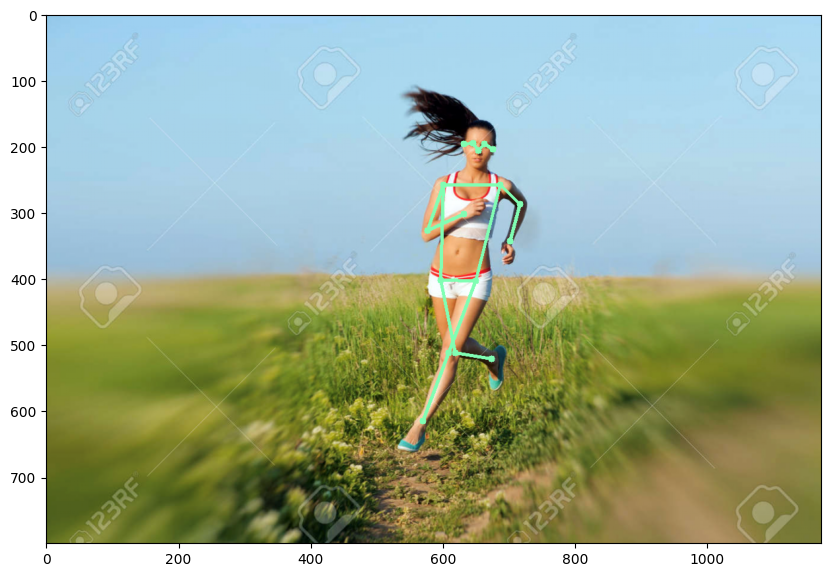

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(runing_girl_result_img)

Получившийся результат выглядит хорошо.


##ЗАДАЧА 2 - сравнение сходства поз на изображениях

###Загрузка дополнительных данных

Загрузим фотографии бегущего мужчины и сидящего мужчины, как образцы с разной степени схожести с референсом

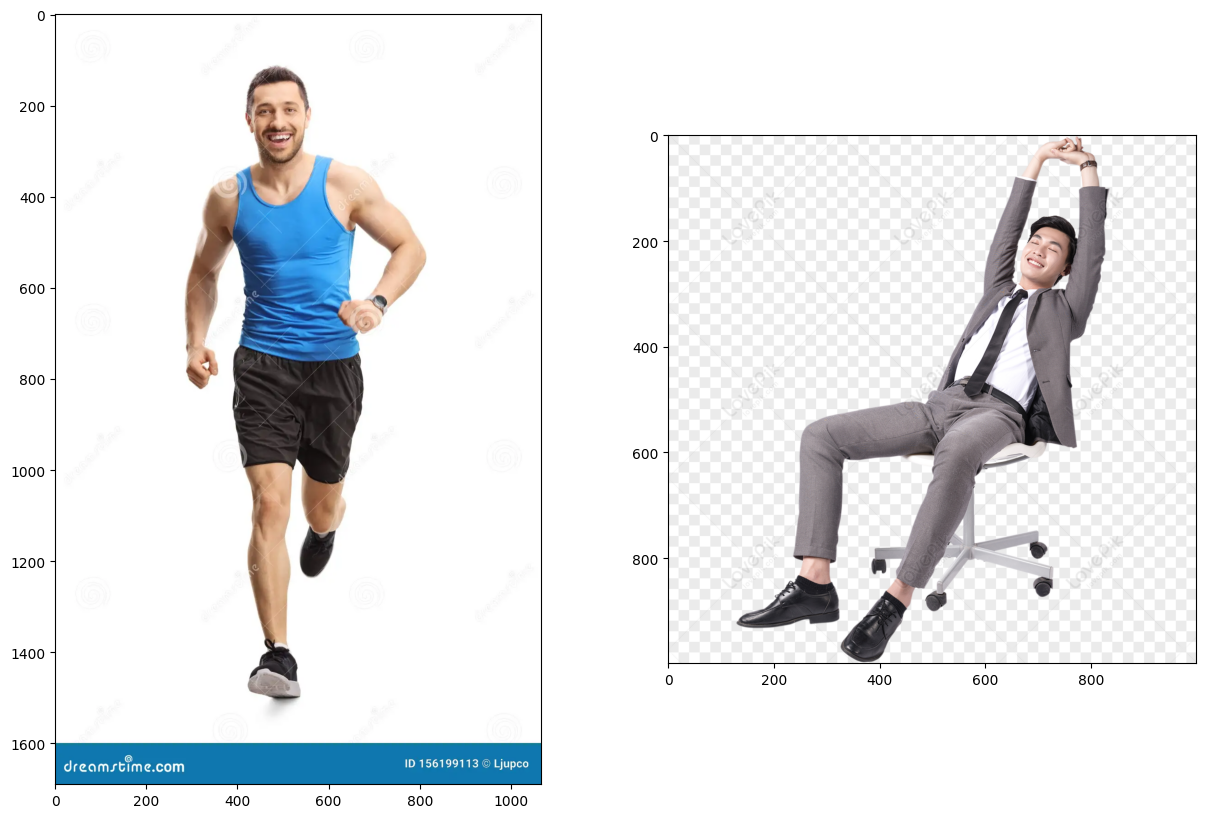

In [16]:
runing_man_img = cv2.imread('runing_man.jpg')
runing_man_img = cv2.cvtColor(runing_man_img, cv2.COLOR_BGR2RGB)
sitting_man_img = cv2.imread('sitting_man.png')
sitting_man_img = cv2.cvtColor(sitting_man_img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(runing_man_img)
ax[1].imshow(sitting_man_img)

Применим трансформацию к изображениям

In [17]:
transf_runing_man_img = transform(runing_man_img)
transf_sitting_man_img = transform(sitting_man_img)

Подадим изображения в модели и сохраним результаты в переменные

In [18]:
output_runing_man = model(transf_runing_man_img.unsqueeze(0))
output_sitting_man = model(transf_sitting_man_img.unsqueeze(0))

Отрисуем каркасы тел

In [19]:
runing_man_result_img = draw_skillet(transf_runing_man_img, output_runing_man[0]['keypoints'], output_runing_man[0]['keypoints_scores'], output_runing_man[0]['scores'], limbs)
sitting_man_result_img = draw_skillet(transf_sitting_man_img, output_sitting_man[0]['keypoints'], output_sitting_man[0]['keypoints_scores'], output_sitting_man[0]['scores'], limbs)

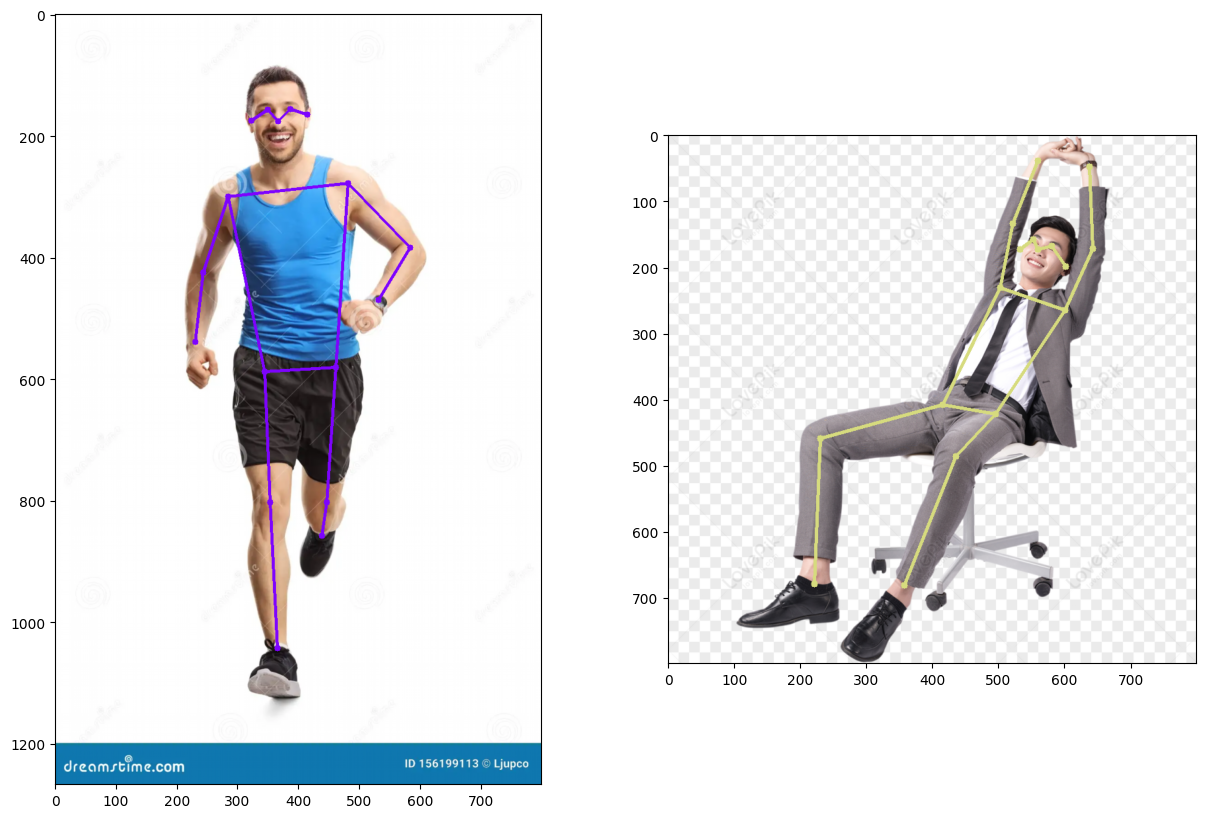

In [20]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(runing_man_result_img)
ax[1].imshow(sitting_man_result_img)

Итак, изоражения загружены, каркасы тел отрисовались верно.

Теперь для наглядности изобразим вектора разных честей тел разными цветами и покажем все изображения одновременно

In [21]:
def get_limbs_with_colour(limbs):
  num_keypoints = len(limbs)
  cmap = plt.get_cmap("rainbow")
  colour_step=255 // num_keypoints # Зададим шаг цвета
  result = []
  for i in range(num_keypoints):
    colour = cmap(i * colour_step / 255)
    result.append({'kp': limbs[i], 'colour': colour})
  return result
limbs_with_colour = get_limbs_with_colour(limbs)

In [22]:
def draw_coloured_skillet(img, all_keypoints, all_scores, confs, limbs_with_colour, keypoint_threshold=2, conf_threshold=0.9):
    if(type(img) == torch.Tensor):
      img = img.permute(1, 2, 0).numpy()
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        kp_array=[]
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            keypoints_restored = []
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    keypoints_restored.append(keypoint)
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]))
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)
            for limb in limbs_with_colour:
              first = limb['kp'][0]
              second = limb['kp'][1]
              if (scores[first] and scores[second])>keypoint_threshold:
                cv2.line(img_copy, keypoints_restored[first], keypoints_restored[second], limb['colour'], 3)

    return img_copy

In [23]:
runing_man_result_img = draw_coloured_skillet(transf_runing_man_img, output_runing_man[0]['keypoints'], output_runing_man[0]['keypoints_scores'], output_runing_man[0]['scores'], limbs_with_colour)
sitting_man_result_img = draw_coloured_skillet(transf_sitting_man_img, output_sitting_man[0]['keypoints'], output_sitting_man[0]['keypoints_scores'], output_sitting_man[0]['scores'], limbs_with_colour)
runing_girl_result_img = draw_coloured_skillet(transf_runing_girl_img, output_runing_girl[0]['keypoints'], output_runing_girl[0]['keypoints_scores'], output_runing_girl[0]['scores'], limbs_with_colour)

Text(0.5, 1.0, 'Sitting man')

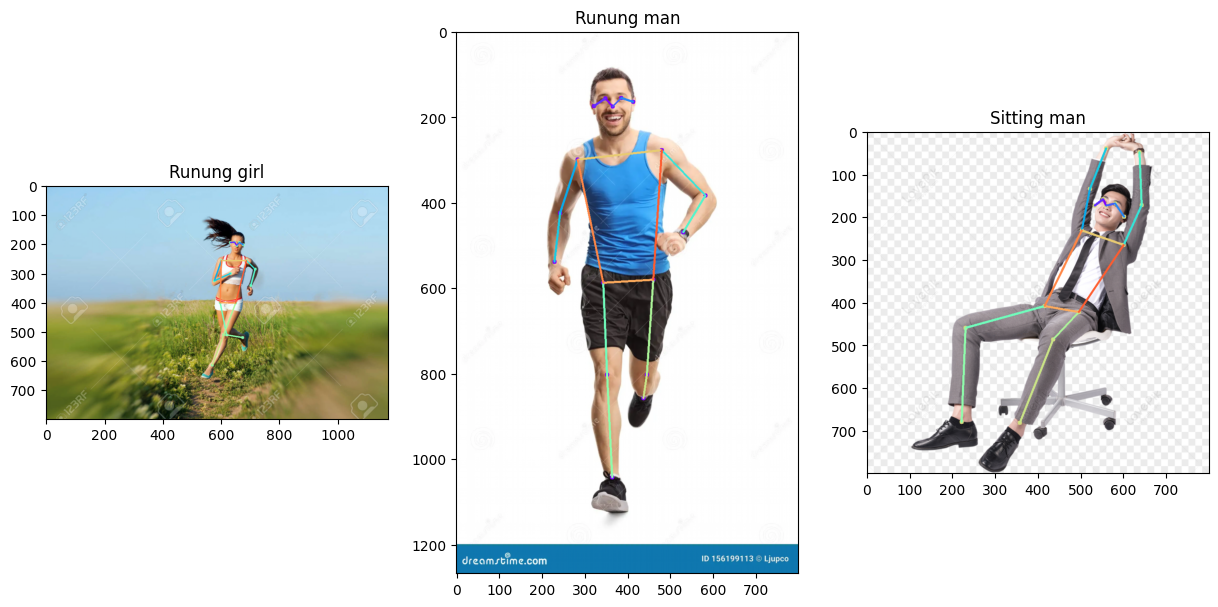

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(runing_girl_result_img)
ax[0].set_title('Runung girl')
ax[1].imshow(runing_man_result_img)
ax[1].set_title('Runung man')
ax[2].imshow(sitting_man_result_img)
ax[2].set_title('Sitting man')

Взгляду человека видна разница и степень сходства поз, теперь нужжно сделать алгоритм который позволит компьтеру найти эту разницу и выразить ее численно

###Анализ сходства поз

###Предварительные преобразования

Т.к. в выводе модели имеется по несколько распознынных объектов с разной степенью достоверности, то для дальнейшего анализа и удобства отберем результаты с самой высокой достоверностью и сохраним их в словарь

In [25]:
def get_keypoints_for_relevant_person(keypoints, confs, person_threshold=0.9):
  result = []
  for person_id in range(len(keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > person_threshold:
          result.append(keypoints[person_id, ...])
  return result

In [26]:
images_keypoints = [{'title':'Runing girl', 'keypoints': get_keypoints_for_relevant_person(output_runing_girl[0]['keypoints'], output_runing_girl[0]['scores'])},
{'title': 'Runung man', 'keypoints': get_keypoints_for_relevant_person(output_runing_man[0]['keypoints'], output_runing_man[0]['scores'])},
{'title': 'Sitting man', 'keypoints': get_keypoints_for_relevant_person(output_sitting_man[0]['keypoints'], output_sitting_man[0]['scores'])}]

Отрисуем вектора опорных точек

In [27]:
def plot_vectors(vectors, figure, title):
  for i in range(len(vectors)):
    if(type(vectors)==torch.Tensor):
      kp = vectors[i].detach().numpy().copy()
    else:
      kp = vectors[i].copy()
    xs = [0,kp[0]]
    ys = [0,kp[1]]
    figure.plot(xs,ys)
    figure.set_title(title)

In [28]:
def clip_keypoints_dimension(keypoints):
    if type(keypoints[0])==torch.Tensor:
      kps = keypoints[0].detach().numpy().copy()
    else:
      kps = keypoints[0].copy()
    return kps[:, :-1]

for im_kps in images_keypoints:
  im_kps["cliped_keypoints"] = clip_keypoints_dimension(im_kps['keypoints'])

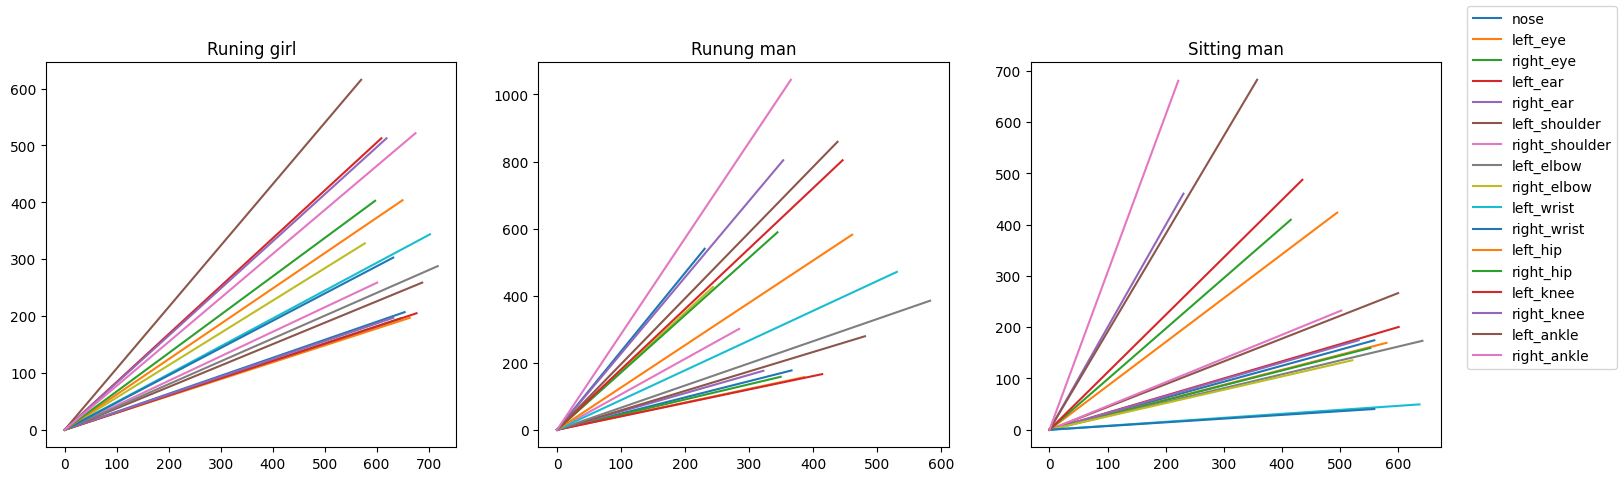

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i in range(3):
  plot_vectors(images_keypoints[i]['cliped_keypoints'], ax[i], images_keypoints[i]['title'])
fig.legend(keypoints)
plt.show()


Полученные вектора показывают нам, что все они находятся в одной честверти, и малоинформативны, например для меры косинусной близости. Поэтому произведем преобразования поз в 3 этапа - сдвинем их все в начало координат с центорм на пересечении диагоналей туловища, затем совершим поворот и масштабирование.
Это поможетнам разные вектора разнести в разные честверти системы координат.
Кроме того масштабирование поворот и перенос также необходимы для сравнения методом евклидова расстояния

Во первых транспонируем фигуры в начало координат, для чего найдем пересечения диагооналей между линиями образованными верхне левой точкой-нижне правой и верхне-правой точкой и нижне левой.

In [30]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def transpose_keypoints(keypoints, keypoints_indexes):
  if type(keypoints)==torch.Tensor:
    kps = keypoints.detach().numpy().copy()
  else:
    kps = keypoints.copy()

  # Базовые точки туловища
  left_hip = kps[keypoints_indexes.index('left_hip')]
  right_hip = kps[keypoints_indexes.index('right_hip')]
  left_shoulder = kps[keypoints_indexes.index('left_shoulder')]
  right_shoulder = kps[keypoints_indexes.index('right_shoulder')]
  body_center = np.array(line_intersection([left_hip, right_shoulder], [right_hip, left_shoulder]))
  result = []
  for kp in kps:
    result.append(kp - body_center)
  return result

Отричуем полученные каркасы

In [31]:
for i in range(3):
  images_keypoints[i]['transposed_keypoints'] = transpose_keypoints(images_keypoints[i]['cliped_keypoints'], keypoints)

In [32]:
def plot_skillet(kps, limbs, figure, title):
    for limb in limbs_with_colour:
      first = limb['kp'][0]
      second = limb['kp'][1]
      x = [kps[first][0], kps[second][0]]
      y = [kps[first][1], kps[second][1]]
      color = (limb['colour'][0], limb['colour'][2], limb['colour'][3])
      figure.set_title(title)
      plot = figure.plot([x[0], x[1]], [y[0], y[1]], linewidth = 3)
    figure.axes.invert_yaxis()

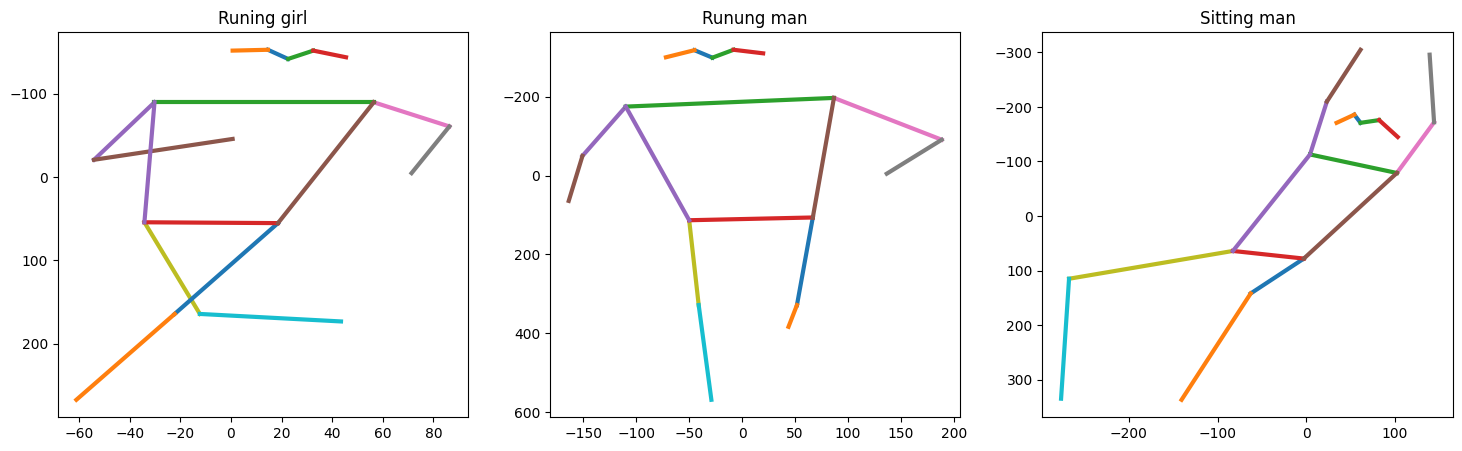

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, im_kps in enumerate(images_keypoints):
  plot_skillet(im_kps['transposed_keypoints'], limbs_with_colour, ax[i], im_kps['title'])
plt.show()

Каркасы перенсены так как и задумано. Теперь произведем поворот фигур. Для этой цели найдем у каждой фигры центральную линию туловища и вычислим косинус и синус угла между ней и осью ординат, чтобы привести все фигуры так чтобы тело было ориентировано вертикально (это нужно например для верной оценки поз независимо от того под каким углом была произведена съемка)
Вращение будем производить по матрице поворота -
\begin{bmatrix} cos(a), -sin(a) \\\ -sin(a), cos(a) \end{bmatrix}

In [34]:
def rotate_keypoints(keypoints, keypoints_indexes):
  if type(keypoints)==torch.Tensor:
    kps = keypoints.detach().numpy().copy()
  else:
    kps = keypoints.copy()

  # Базовые точки туловища
  left_hip = kps[keypoints_indexes.index('left_hip')]
  right_hip = kps[keypoints_indexes.index('right_hip')]
  left_shoulder = kps[keypoints_indexes.index('left_shoulder')]
  right_shoulder = kps[keypoints_indexes.index('right_shoulder')]
  inter_hips_dot = right_hip + (left_hip - right_hip)/2
  inter_shoulders_dot = right_shoulder + (left_shoulder - right_shoulder)/2
  body_vector = inter_hips_dot - inter_shoulders_dot
  magnitude = np.linalg.norm(body_vector)
  sin = body_vector[0] / magnitude
  cos = body_vector[1] / magnitude
  M = np.array(((cos, -sin), (sin, cos)))
  return np.dot(kps, M.T)

In [35]:
for i in range(3):
  images_keypoints[i]['rotated_keypoints'] = rotate_keypoints(images_keypoints[i]['transposed_keypoints'], keypoints)

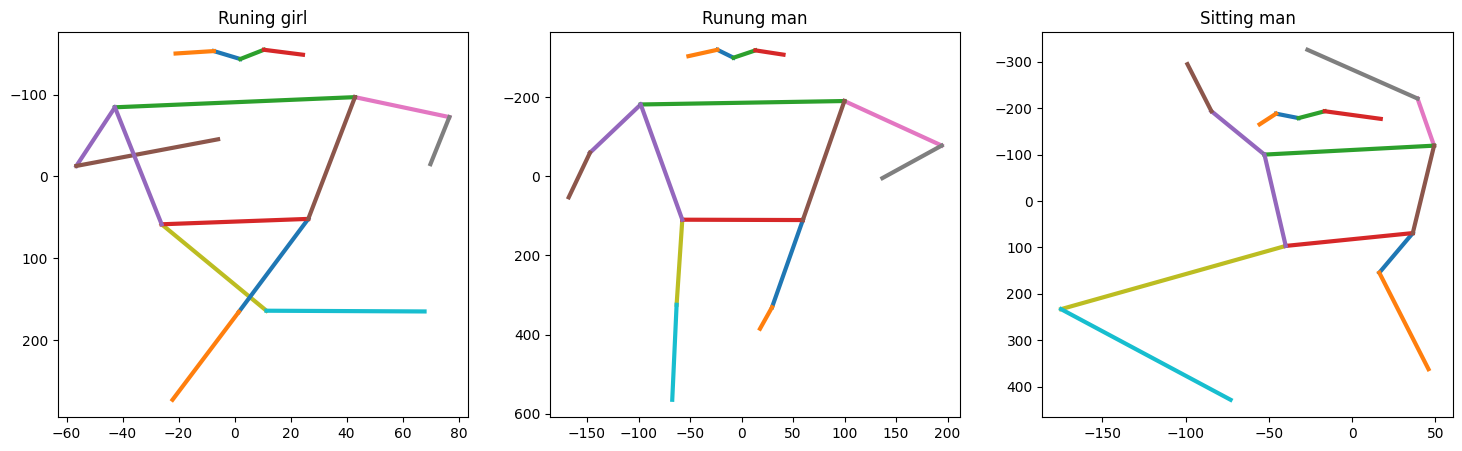

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, im_kps in enumerate(images_keypoints):
  plot_skillet(im_kps['rotated_keypoints'], limbs_with_colour, ax[i], im_kps['title'])
plt.show()

Отлично, фигуры развернуты в одинаковом направлении.

Теперь произведем масштабирование так чтобы средняя линия туловища была равна одному и тому же расстоянию. При этом матрица преобразования будет выглядеть следующим образом
\begin{bmatrix} 1/scale, 0 \\\ 0, 1/scale \end{bmatrix}
где scale - коэффициент масштабирования

In [37]:
def scale_keypoints(keypoints, keypoints_indexes):
  if type(keypoints)==torch.Tensor:
    kps = keypoints.detach().numpy().copy()
  else:
    kps = keypoints.copy()

  # Базовые точки туловища
  left_hip = kps[keypoints_indexes.index('left_hip')]
  right_hip = kps[keypoints_indexes.index('right_hip')]
  left_shoulder = kps[keypoints_indexes.index('left_shoulder')]
  right_shoulder = kps[keypoints_indexes.index('right_shoulder')]
  inter_hips_dot = right_hip + (left_hip - right_hip)/2
  inter_shoulders_dot = right_shoulder + (left_shoulder - right_shoulder)/2
  body_vector = inter_hips_dot - inter_shoulders_dot
  scale = np.linalg.norm(body_vector/500)
  M = np.array(((1 / scale, 0), (0, 1 / scale)))
  return np.dot(kps, M.T)

In [38]:
for i in range(3):
  images_keypoints[i]['final_keypoints'] = scale_keypoints(images_keypoints[i]['rotated_keypoints'], keypoints)

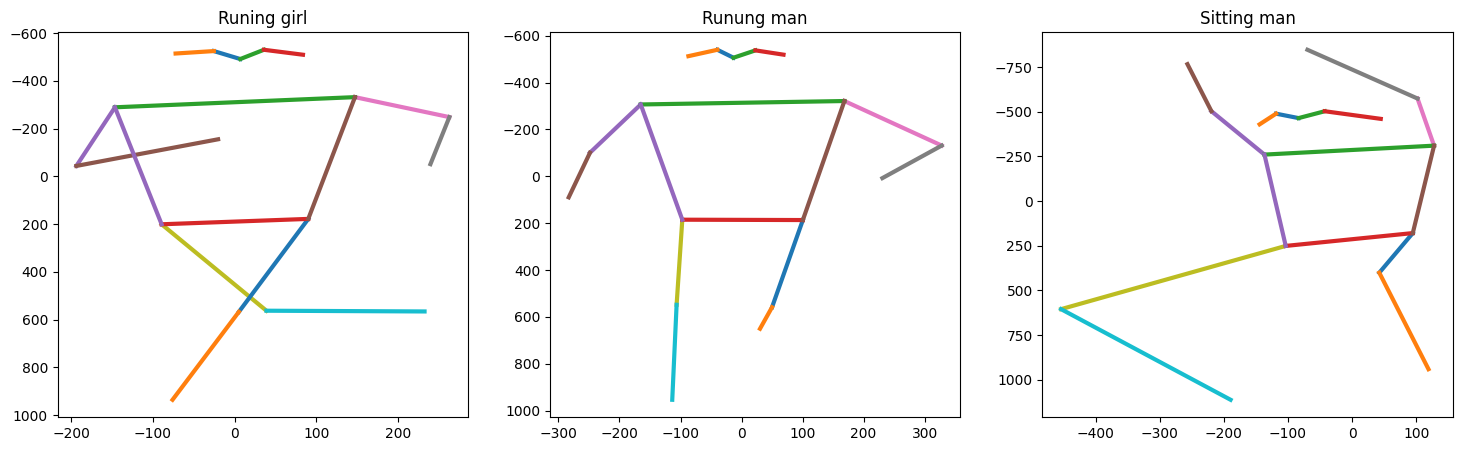

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, im_kps in enumerate(images_keypoints):
  plot_skillet(im_kps['final_keypoints'], limbs_with_colour, ax[i], im_kps['title'])
plt.show()

Итак фигуры преобразованны

Перейдем к анализу метрик

###Оценка метрик

Отрисуем получившиеся вектора после преобразований

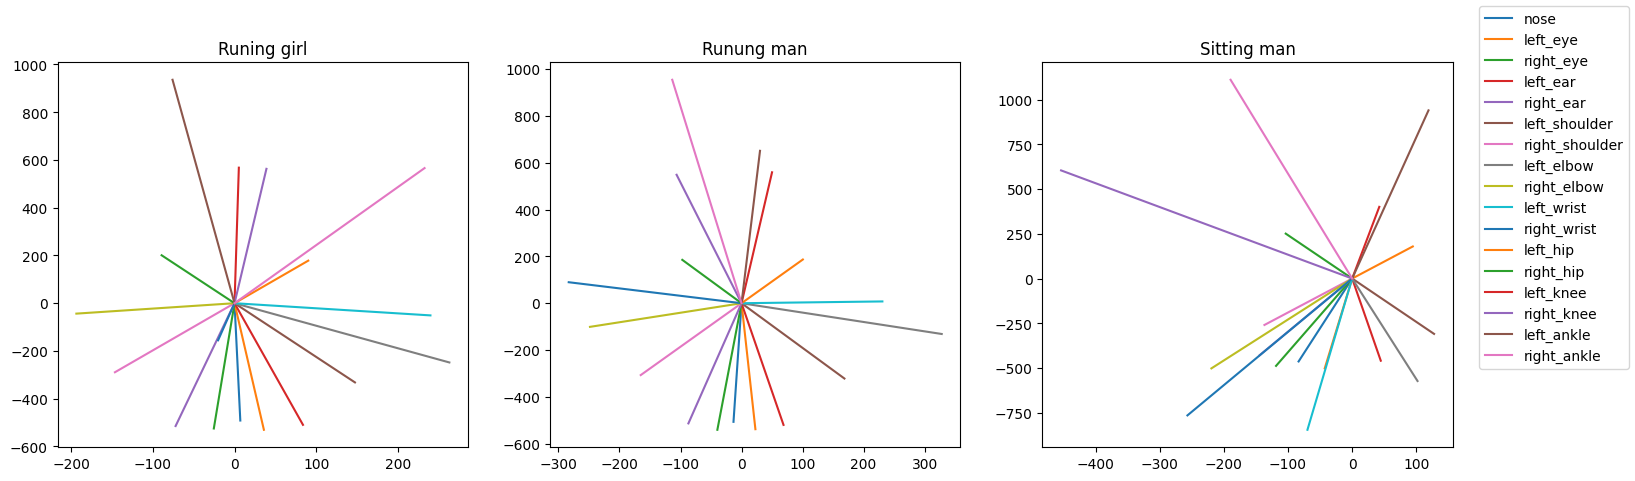

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i in range(3):
  plot_vectors(images_keypoints[i]['final_keypoints'], ax[i], images_keypoints[i]['title'])
fig.legend(keypoints)
plt.show()

Теперь вектора опорных точек выглядят лучше, чем до преобразований - назодятся в разных четвертях системы координат и масштабированы

Зададим две функции - косинусной близости и взвешенного расстояния.

Для расчета косинусной близости воспользуемся функцией из пакета sklearn и выделем из нее главную диагональ, на которой и будут содержатся интересующие нас оценки

Для оценки взвшенного расстояния будем использовать сумму обратных коэффициентов достоверности умноженную на сумму произведений коэффициента достоверности на модуль еклидова расстояния между сравниваемыми веторами

In [41]:
def cosine_distance(pose1, pose2):
    return np.diagonal(cosine_similarity(pose1, pose2))


def weight_distance(pose1, pose2, conf1):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||pose1 - pose2||) = sum1 * sum2
    if type(conf1)==torch.Tensor:
      conf1 = conf1.detach().numpy()[0].copy()
    else:
      conf1 = conf1[0].copy()
    sum1 = 1 / np.sum(conf1)
    sum2 = 0

    for i in range(len(pose1)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        conf_ind = math.floor(i / 2)
        sum2 += conf1[conf_ind] * abs(pose1[i] - pose2[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

Расчитаем косинусную близость

In [42]:

runing_girl_vs_runing_man_cosin_score = cosine_distance(images_keypoints[0]['final_keypoints'], images_keypoints[1]['final_keypoints'])
runing_girl_vs_sitting_man_cosin_score = cosine_distance(images_keypoints[0]['final_keypoints'], images_keypoints[2]['final_keypoints'])
runing_man_vs_sitting_man_cosin_score = cosine_distance(images_keypoints[1]['final_keypoints'], images_keypoints[2]['final_keypoints'])
runing_girl_vs_self = cosine_distance(images_keypoints[0]['final_keypoints'], images_keypoints[0]['final_keypoints'])

In [43]:
print(f'Косинусная близость между позами бегущей девушки и бегущего мужчины составляет {np.round(np.mean(runing_girl_vs_runing_man_cosin_score), 3)}')
print(f'Косинусная близость между позами бегущей девушки и сидящего мужчины составляет {np.round(np.mean(runing_girl_vs_sitting_man_cosin_score), 3)}')
print(f'Косинусная близость между позами сидящего мужчины и бегущего мужчины составляет {np.round(np.mean(runing_man_vs_sitting_man_cosin_score), 3)}')
print(f'Косинусная близость позы с самой собой составляет {np.round(np.mean(runing_girl_vs_self), 3)}')

Косинусная близость между позами бегущей девушки и бегущего мужчины составляет 0.914
Косинусная близость между позами бегущей девушки и сидящего мужчины составляет 0.883
Косинусная близость между позами сидящего мужчины и бегущего мужчины составляет 0.823
Косинусная близость позы с самой собой составляет 1.0


Итак оценки косинусной близости ожидаемо выше для бугущих девуши и мужчины и ниже при их сравнении с позой сидящего мужчины. Однако, даже значения сильно тличающихся поз выше 0.8. Для устранения этой проблеммы нужно будет посмотреть на результаты отдельных векторов

In [44]:
print(runing_girl_vs_sitting_man_cosin_score)

[0.98152612 0.9883794  0.98201538 0.9977994  0.98293553 0.99962832
 0.99987343 0.80289791 0.59156488 0.1270296  0.98110291 0.9998734
 0.99962836 0.9954219  0.75656091 0.97871596 0.84788357]


Итак видно, что занчения косинусной близости многих векторов близки к единице - это вектора тела и головы - которые мало меняются из-за того, какое преобразование мы провели. Для дальнеших расчетом нужно будет произвести определенные изменения.

Но сейчас посмотрим на значения взвешенного расстояния

In [45]:
runing_girl_vs_runing_man_weight_distance_score = weight_distance(images_keypoints[0]['final_keypoints'], images_keypoints[1]['final_keypoints'], output_runing_man[0]['keypoints_scores'])
runing_girl_vs_sitting_man_weight_distance_score = weight_distance(images_keypoints[0]['final_keypoints'], images_keypoints[2]['final_keypoints'], output_sitting_man[0]['keypoints_scores'])
runing_man_vs_sitting_man_weight_distance_score = weight_distance(images_keypoints[1]['final_keypoints'], images_keypoints[2]['final_keypoints'], output_sitting_man[0]['keypoints_scores'])
runing_girl_vs_self_weight_distance_score = weight_distance(images_keypoints[0]['final_keypoints'], images_keypoints[0]['final_keypoints'], output_runing_girl[0]['keypoints_scores'])

In [46]:
print(f'Взвешенное расстояние между позами бегущей девушки и бегущего мужчины составляет {np.round(np.mean(runing_girl_vs_runing_man_weight_distance_score), 3)}')
print(f'Взвешенное расстояние между позами бегущей девушки и сидящего мужчины составляет {np.round(np.mean(runing_girl_vs_sitting_man_weight_distance_score), 3)}')
print(f'Взвешенное расстояние между позами сидящего мужчины и бегущего мужчины составляет {np.round(np.mean(runing_man_vs_sitting_man_weight_distance_score), 3)}')
print(f'Взвешенное расстояние позы с самой собой составляет {np.round(np.mean(runing_girl_vs_self_weight_distance_score), 3)}')

Взвешенное расстояние между позами бегущей девушки и бегущего мужчины составляет 68.878
Взвешенное расстояние между позами бегущей девушки и сидящего мужчины составляет 160.471
Взвешенное расстояние между позами сидящего мужчины и бегущего мужчины составляет 154.688
Взвешенное расстояние позы с самой собой составляет 0.0


При аналице оценки взвешенного расстояния, можно сказать, что она неплохо разделяет похожие и не похожие позы - так величина разницы между позами бегущей девшуки и мужчины с сидящим мужчиной почти одинакова, а меду ними значительно меньше.
Однако, проблема в том, что не совсем понятно как интерпретировать полученные значения - какой порог будет отвечать за хорошее совпадение, а какой за не очень и нет верхней границы этого расстояния.
Поэтому косинусная близость нам подойдет больше - давайте попробуем выполнить преобразования, чтобы добится большего различия в позах.

Изначально одтелим точки конечностей - как более подвижных частей, от точек головы и тела.

In [47]:
body_points = [
    keypoints.index("right_shoulder"),
    keypoints.index("left_shoulder"),
    keypoints.index("right_hip"),
    keypoints.index("left_hip")
]
head_points = [
    keypoints.index("right_eye"),
    keypoints.index("left_eye"),
    keypoints.index("nose"),
    keypoints.index("right_ear"),
    keypoints.index("left_ear"),
]
limbs_vectors = [
    [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
    [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
    [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
    [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
    [keypoints.index("right_hip"), keypoints.index("right_knee")],
    [keypoints.index("right_knee"), keypoints.index("right_ankle")],
    [keypoints.index("left_hip"), keypoints.index("left_knee")],
    [keypoints.index("left_knee"), keypoints.index("left_ankle")],
]

При этом векторы конечностей транспонируем в начало координат. Так мы добьемся того, что сможем отличать углы поворта дистальных частей конечностей отдельно от проксимальных.

In [48]:
def limbs_vectors_by_start_points(pose):
  result = np.empty((len(limbs_vectors), 2))
  for i, limb in enumerate(limbs_vectors):
    result[i] = pose[limb[1]] - pose[limb[0]]
  return result
girl_limbs = limbs_vectors_by_start_points(images_keypoints[0]['final_keypoints'])
r_m = limbs_vectors_by_start_points(images_keypoints[1]['final_keypoints'])
s_m = limbs_vectors_by_start_points(images_keypoints[2]['final_keypoints'])

Отрисуем получившиея вектора

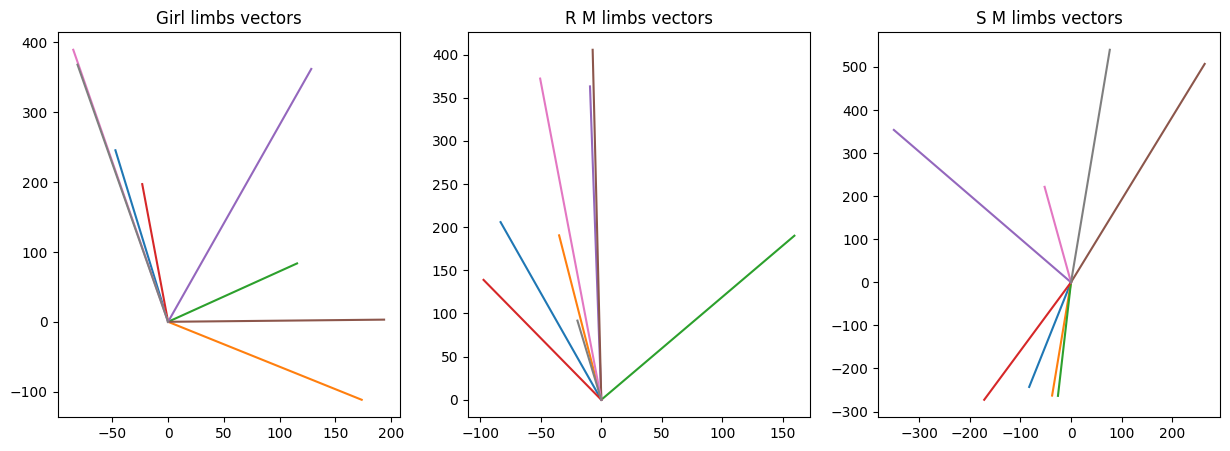

In [49]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
plot_vectors(girl_limbs, ax[0], "Girl limbs vectors")
plot_vectors(r_m, ax[1], "R M limbs vectors")
plot_vectors(s_m, ax[2], "S M limbs vectors")

Видно, что вектора конечностей сидящего мужчины значительно тличаются от векторов бегущих фигур.

Посмотрим на косинусную близость между ними

In [50]:
print(f'Girl vs runing man {np.mean(cosine_distance(girl_limbs, r_m))}')
print(f'Girl vs sitting man {np.mean(cosine_distance(girl_limbs, s_m))}')
print(f'Runing man vs sitting man {np.mean(cosine_distance(r_m, s_m))}')

Girl vs runing man 0.634626137631316
Girl vs sitting man 0.11943231935284415
Runing man vs sitting man 0.07771958131326279


Итак, теперь разница между позами по косинусному расстоянию стала гораздо отчетливей.

Теперь высичлим общую оценку позы, после преобразования.
 Для этого оценки точек тела и головы усредним, чтобы получить всего две оценки - так уменьшим их влияние. Кроме того, введем для них коэффициенты, повышеющие чувствительность этих показателей - т.к. преобразования которые мы провли ранее, по своему определнию уменьшают колебания этих векторов.

In [51]:
def body_parts_cosin_score(pose1, pose2, body_coef=10, head_coef=5):
    if type(pose1)==torch.Tensor:
      pose1 = pose1.detach().numpy()
    if type(pose2)==torch.Tensor:
      pose2 = pose2.detach().numpy()
    # Поскольку в результате преобразования позиция туловища оказывается фиксированной,
    # то его вектора будут менятся крайне незначительно.
    # И чтобы придать этим изменениям больший вес возведем значения косинусной близости этих точек в степень
    body_score = cosine_distance(pose1[body_points], pose2[body_points])**body_coef
    # Вектора головы также будут менятся незначительно тк размах ее движений не очень вилик
    # Поэтому тоже возведем их косинусную близость в степень
    head_score = cosine_distance(pose1[head_points], pose2[head_points])**head_coef
    # для финального подсчета голову и туловище будем учитывать как отдельные точки целеком
    limbs_score = cosine_distance(limbs_vectors_by_start_points(pose1), limbs_vectors_by_start_points(pose2))
    scores = [np.mean(body_score), np.mean(head_score)]
    scores.extend(limbs_score)
    return np.mean(scores)

In [52]:
girl_vs_rm = body_parts_cosin_score(images_keypoints[0]['final_keypoints'], images_keypoints[1]['final_keypoints'])
girl_vs_sm = body_parts_cosin_score(images_keypoints[0]['final_keypoints'], images_keypoints[2]['final_keypoints'])
rm_vs_sm = body_parts_cosin_score(images_keypoints[1]['final_keypoints'], images_keypoints[2]['final_keypoints'])

In [53]:
print(f'Girl vs runing man {girl_vs_rm}')
print(f'Girl vs sitting man {girl_vs_sm}')
print(f'Runing man vs sitting man {rm_vs_sm}')

Girl vs runing man 0.7062702463072716
Girl vs sitting man 0.2887781215378316
Runing man vs sitting man 0.2555852627025601


Итак, оценка косинусной близости векторов двух поз теперь стала более информативной и в отличие от взвешенного расстояния - ее лего интерпретироватть - так оценка в 1 - означает совпадение, оценка в 0 - вектора перпендикулярны друг другу, а оценка в -1 означает, что вектора ровно противоположны друг другу.

Поэтому для дальнешей работы будем использовать косинусную близость с теми преобразованиями в векторах, которые мыс сделали.

###Создание модуля для дальнейшей работы

Для удобства последующей работы создадим модуль, в который поместим ункции для расчета сходства поз, а также класс для обработки моделью и последующего преобразования векторов и визуализации результатов.

In [54]:
class pose_model:
    keypoints_name = ['nose','left_eye','right_eye',\
        'left_ear','right_ear','left_shoulder',\
        'right_shoulder','left_elbow','right_elbow',\
        'left_wrist','right_wrist','left_hip',\
        'right_hip','left_knee', 'right_knee', \
        'left_ankle','right_ankle']

    skeleton = [
        [keypoints_name.index("right_eye"), keypoints_name.index("nose")],
        [keypoints_name.index("right_eye"), keypoints_name.index("right_ear")],
        [keypoints_name.index("left_eye"), keypoints_name.index("nose")],
        [keypoints_name.index("left_eye"), keypoints_name.index("left_ear")],
        [keypoints_name.index("right_shoulder"), keypoints_name.index("right_elbow")],
        [keypoints_name.index("right_elbow"), keypoints_name.index("right_wrist")],
        [keypoints_name.index("left_shoulder"), keypoints_name.index("left_elbow")],
        [keypoints_name.index("left_elbow"), keypoints_name.index("left_wrist")],
        [keypoints_name.index("right_hip"), keypoints_name.index("right_knee")],
        [keypoints_name.index("right_knee"), keypoints_name.index("right_ankle")],
        [keypoints_name.index("left_hip"), keypoints_name.index("left_knee")],
        [keypoints_name.index("left_knee"), keypoints_name.index("left_ankle")],
        [keypoints_name.index("right_shoulder"), keypoints_name.index("left_shoulder")],
        [keypoints_name.index("right_hip"), keypoints_name.index("left_hip")],
        [keypoints_name.index("right_shoulder"), keypoints_name.index("right_hip")],
        [keypoints_name.index("left_shoulder"), keypoints_name.index("left_hip")],
    ]

    body_points = [
        keypoints_name.index("right_shoulder"),
        keypoints_name.index("left_shoulder"),
        keypoints_name.index("right_hip"),
        keypoints_name.index("left_hip")
    ]
    head_points = [
        keypoints_name.index("right_eye"),
        keypoints_name.index("left_eye"),
        keypoints_name.index("nose"),
        keypoints_name.index("right_ear"),
        keypoints_name.index("left_ear"),
    ]
    limbs_vectors = [
        [keypoints_name.index("right_shoulder"), keypoints_name.index("right_elbow")],
        [keypoints_name.index("right_elbow"), keypoints_name.index("right_wrist")],
        [keypoints_name.index("left_shoulder"), keypoints_name.index("left_elbow")],
        [keypoints_name.index("left_elbow"), keypoints_name.index("left_wrist")],
        [keypoints_name.index("right_hip"), keypoints_name.index("right_knee")],
        [keypoints_name.index("right_knee"), keypoints_name.index("right_ankle")],
        [keypoints_name.index("left_hip"), keypoints_name.index("left_knee")],
        [keypoints_name.index("left_knee"), keypoints_name.index("left_ankle")],
    ]

    def __init__(self, pose_image, body_coef = 10, head_coef = 5, body_height = 500):
        self.head_coef = head_coef
        self.body_coef = body_coef
        self.body_height = body_height
        self.model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=torchvision.models.detection.KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
        self.transform = v2.Compose([torchvision.transforms.ToTensor()])
        self.image = self.transform(pose_image)
        self.model.eval()
        self.model_output = self.model(self.image.unsqueeze(0))[0]
        self.cmap = plt.get_cmap("rainbow")
        self.model_keypoints, self.model_scores = self.get_output_for_person(self.model_output)
        self.add_colors_to_skeleton()
        self.transformed_keypoints = self.transorm_pose()
        self.limbs_vectors_by_start_points = self.create_limbs_vectors_by_start_points()


    def get_output_for_person(self, input):
        person_index = torch.argmax(input['scores'])
        return input['keypoints'][person_index, ...][...,:-1], input['keypoints_scores'][person_index, ...]

    def add_colors_to_skeleton(self):
        num_keypoints = len(self.skeleton)
        colour_step=255 // num_keypoints # Зададим шаг цвета
        for i in range(num_keypoints):
            colour = self.cmap(i * colour_step / 255)
            self.skeleton[i].append(colour)

    def draw_coloured_skeleton(self, keypoint_threshold=2, line_thickness=5):
        if(type(self.image) == torch.Tensor):
          img = self.image.permute(1, 2, 0).numpy()
        # создаём копию изображений
        img_copy = img.copy()
        color = (0, 255, 0)
        keypoints_restored = []
        for kp in range(len(self.model_scores)):
            # проверяем степень уверенности детектора опорной точки
            if self.model_scores[kp] > keypoint_threshold:
                # конвертируем массив ключевых точек в список целых чисел
                keypoint = tuple(
                    map(int, self.model_keypoints[kp].detach().numpy().tolist())
                )
                keypoints_restored.append(keypoint)
                # рисуем кружок радиуса 5 вокруг точки
                cv2.circle(img_copy, keypoint, 5, color, -1)
        for limb in self.skeleton:
          first = limb[0]
          second = limb[1]
          if (self.model_scores[first] and self.model_scores[second])>keypoint_threshold:
            cv2.line(img_copy, keypoints_restored[first], keypoints_restored[second], limb[2], line_thickness)
        return img_copy

    def transpose_keypoints(self, keypoints):
        if type(keypoints)==torch.Tensor:
            kps = keypoints.detach().numpy().copy()
        else:
            kps = keypoints.copy()

        # Базовые точки туловища
        left_hip = kps[self.keypoints_name.index('left_hip')]
        right_hip = kps[self.keypoints_name.index('right_hip')]
        left_shoulder = kps[self.keypoints_name.index('left_shoulder')]
        right_shoulder = kps[self.keypoints_name.index('right_shoulder')]
        body_center = np.array(line_intersection([left_hip, right_shoulder], [right_hip, left_shoulder]))
        result = []
        for kp in kps:
            result.append(kp - body_center)
        return result

    def rotate_keypoints(self, keypoints):
        if type(keypoints)==torch.Tensor:
            kps = keypoints.detach().numpy()
        else:
            kps = keypoints

        # Базовые точки туловища
        left_hip = kps[self.keypoints_name.index('left_hip')]
        right_hip = kps[self.keypoints_name.index('right_hip')]
        left_shoulder = kps[self.keypoints_name.index('left_shoulder')]
        right_shoulder = kps[self.keypoints_name.index('right_shoulder')]
        inter_hips_dot = right_hip + (left_hip - right_hip)/2
        inter_shoulders_dot = right_shoulder + (left_shoulder - right_shoulder)/2
        self.body_vector = inter_hips_dot - inter_shoulders_dot
        magnitude = np.linalg.norm(self.body_vector)
        sin = self.body_vector[0] / magnitude
        cos = self.body_vector[1] / magnitude
        M = np.array(((cos, -sin), (sin, cos)))
        return np.dot(kps, M.T)

    def scale_keypoints(self, keypoints):
        if type(keypoints)==torch.Tensor:
            kps = keypoints.detach().numpy()
        else:
            kps = keypoints
        scale = np.linalg.norm(self.body_vector / self.body_height)
        M = np.array(((1 / scale, 0), (0, 1 / scale)))
        return np.dot(kps, M.T)

    def transorm_pose(self):
        transformed = self.transpose_keypoints(self.model_keypoints)
        transformed = self.rotate_keypoints(transformed)
        return self.scale_keypoints(transformed)

    def create_limbs_vectors_by_start_points(self):
        result = np.empty((len(self.limbs_vectors), 2))
        for i, limb in enumerate(self.limbs_vectors):
            result[i] = self.transformed_keypoints[limb[1]] - self.transformed_keypoints[limb[0]]
        return result

    def body_parts_cosin_score(self, pose_to_compare, body_coef=10, head_coef=5):
        pose1 = self.transformed_keypoints
        pose2 = pose_to_compare.transformed_keypoints
        if type(pose1)==torch.Tensor:
            pose1 = pose1.detach().numpy()
        if type(pose2)==torch.Tensor:
            pose2 = pose2.detach().numpy()
        # Поскольку в результате преобразования позиция туловища оказывается фиксированной,
        # то его вектора будут менятся крайне незначительно.
        # И чтобы придать этим изменениям больший вес возведем значения косинусной близости этих точек в степень
        body_score = cosine_similarity(pose1[self.body_points], pose2[self.body_points])**body_coef
        # Вектора головы также будут менятся незначительно тк размах ее движений не очень вилик
        # Поэтому тоже возведем их косинусную близость в степень
        head_score = cosine_similarity(pose1[self.head_points], pose2[self.head_points])**head_coef
        # для финального подсчета голову и туловище будем учитывать как отдельные точки целеком
        limbs_score = cosine_similarity(self.limbs_vectors_by_start_points, pose_to_compare.limbs_vectors_by_start_points)
        scores = [np.mean(body_score), np.mean(head_score)]
        scores.extend(limbs_score)
        return np.mean(scores), limbs_score, body_score, head_score

    def plot_skeleton(self,  figure, title):
        for limb in self.skeleton:
            first = limb[0]
            second = limb[1]
            x = [self.transformed_keypoints[first][0], self.transformed_keypoints[second][0]]
            y = [self.transformed_keypoints[first][1], self.transformed_keypoints[second][1]]
            figure.set_title(title)
            plot = figure.plot([x[0], x[1]], [y[0], y[1]], linewidth = 3)
        figure.axes.invert_yaxis()


Загрузим получившийся модуль и посмотрим как он работает

In [61]:
import importlib
import pose_detection_utils
importlib.reload(pose_detection_utils)

<module 'pose_detection_utils' from '/content/pose_detection_utils.py'>

In [62]:
models = [[pose_detection_utils.pose_model(runing_girl_img), 'Runing girl'],
          [pose_detection_utils.pose_model(runing_man_img), 'Runing man'],
          [pose_detection_utils.pose_model(sitting_man_img), 'Siting man']]

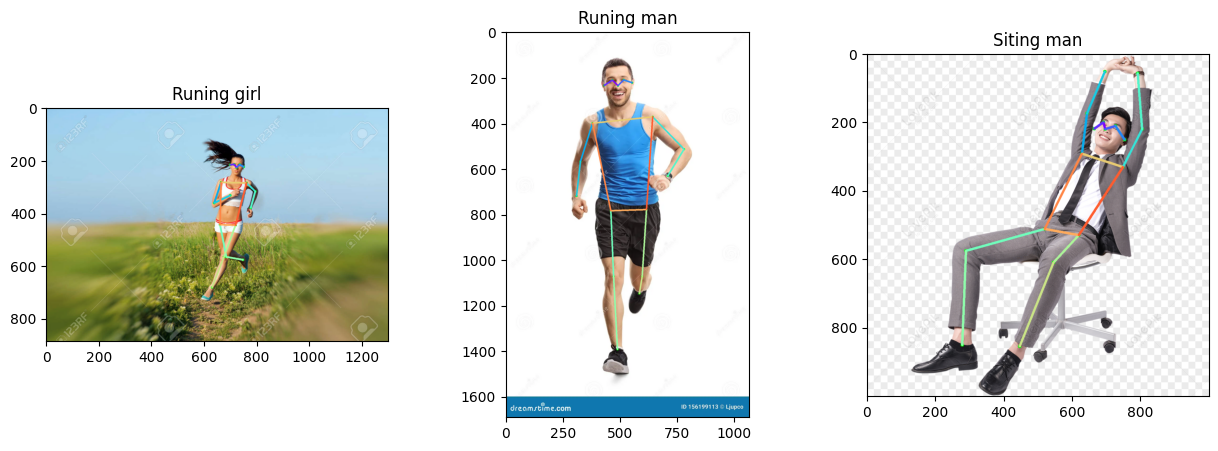

In [63]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
for i, m in enumerate(models):
  ax[i].imshow(m[0].draw_coloured_skeleton())
  ax[i].set_title(m[1])

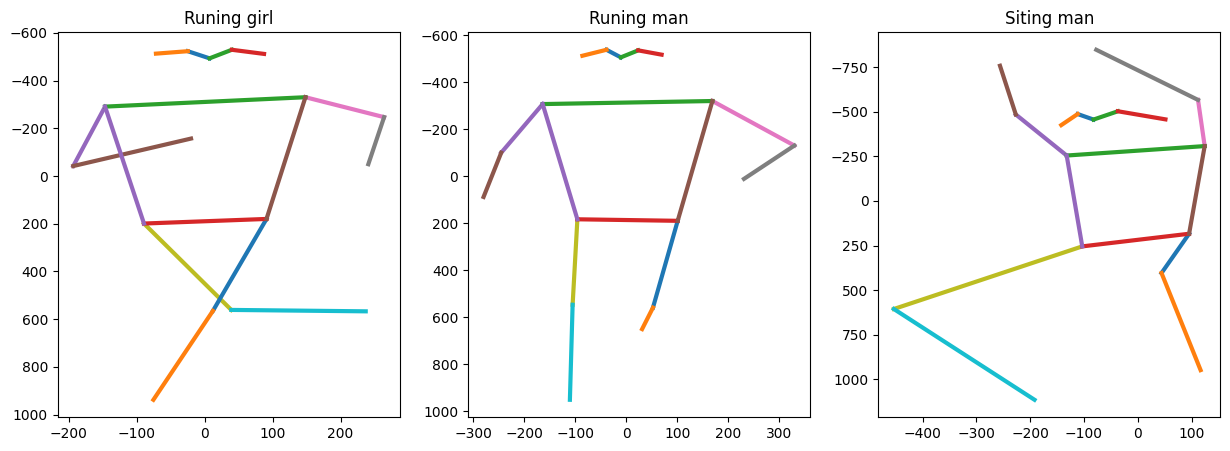

In [59]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
for i, m in enumerate(models):
  m[0].plot_skeleton(ax[i], m[1])

In [60]:
print("Body parts cosin scores:")
print(f'Girl vs runing man {models[0][0].body_parts_cosin_score(models[1][0])}')
print(f'Girl vs sitting man {models[0][0].body_parts_cosin_score(models[2][0])}')
print(f'Runing man vs sitting man {models[1][0].body_parts_cosin_score(models[2][0])}')

Body parts cosin scores:
Girl vs runing man (0.7073987327213355, array([ 0.9822673 , -0.69463146,  0.97070401,  0.88155315,  0.93340718,
        0.01649736,  0.99744291,  0.99999864]), array([0.99758411, 0.98083854, 0.98083962, 0.99758441]), array([0.99850583, 0.99745276, 0.99683878, 0.99817825, 0.99670719]))
Girl vs sitting man (0.30231789340399784, array([-0.83866055,  0.46081184, -0.62308281, -0.75847454,  0.43040914,
        0.48350629,  0.99964053,  0.93457635]), array([0.99935094, 0.99308563, 0.99308518, 0.99935107]), array([0.92359059, 0.94610781, 0.91087631, 0.91864254, 0.99195519]))
Runing man vs sitting man (0.2638430920977024, array([-0.72167382, -0.95853   , -0.79276417, -0.36097672,  0.72562912,
        0.88319834,  0.99516825,  0.9351623 ]), array([0.9994385 , 0.95169028, 0.95169079, 0.99943853]), array([0.94266151, 0.96648026, 0.93996174, 0.94021286, 0.99894904]))


Отлично - модуль работает так как и задумано.

Работа над 2 этапом завершена.

Работа над 3 задачей во втором ноутбуке.